# MIS 284N Assignment 3

Group Member: Rehan Daya, Mauricio Morales, Anqi Lou, Yue Tian, Qinwen Zhou
(all from 8:30-10:30 session)

### Scrape data from Zara Instagram

Website used:https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans
(Page 1-100)

In [ ]:
!pip install selenium
!apt-get -q update
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

import pandas as pd
driver = webdriver.Chrome('chromedriver', options=chrome_options)

!pip install instaloader
from instaloader import instaloader, Profile
import time
sys.setrecursionlimit(10000)
from datetime import datetime
from itertools import dropwhile, takewhile



In [ ]:
L = instaloader.Instaloader()
L.login("username","password") #username and log in here separated by comma for instagram account
df=pd.DataFrame()

In [ ]:
i=0
for post in instaloader.Profile.from_username(L.context, 'zara').get_posts():
    df = df.append({'Caption': post.caption, 'Likes':post.likes, 'URL':post.url,'Comments':post.comments},ignore_index=True)
    i=i+1
    if i>400:
        break   
df.to_excel("zara.xlsx",index=False)
print("Written to zara.xlsx file")


In [ ]:
#Excel file with URL only
df2=df.drop(columns=['Caption','Likes','Comments'])
df2.to_excel("zara_mod.xlsx",index=False)

In [ ]:
#!pip install --upgrade google-api-python-client
!pip install google-cloud    
!pip install google-cloud-vision
import xlrd
from google.cloud import vision
import os
import pandas as pd

In [ ]:
Application_Credentials = '.json' #Add API key here from Google Cloud Vision, its a .json file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = Application_Credentials
client = vision.ImageAnnotatorClient()
image = vision.Image() 

loc= ("zara_mod.xlsx")
wb= xlrd.open_workbook(loc)
sheet = wb.sheet_by_index(0)
sheet.cell_value(0, 0)
df3=pd.DataFrame()

#loop through every url, retrieve the image  and send to google vision
for i in range (sheet.nrows):
    image_src_temp = sheet.cell_value(i,0)
    image.source.image_uri = image_src_temp
    response = client.label_detection(image=image)
    labels = response.label_annotations
    l=[]
    for label in labels:
        l.append(label.description)
    s= ' '.join(l)
    print("s")
    print(s)
    df3=df3.append({'URL': image_src_temp, 'Labels':s}, ignore_index = True)
df3.to_excel("Labels.xlsx", index=False)

In [ ]:
df3_copy = df3.copy()
df3_copy = df3_copy.iloc[1:]
df3_copy.reset_index(drop=True, inplace=True)
df3_copy

In [ ]:
#combine labels with origional excel file
df['Labels']=df3_copy['Labels']

In [ ]:
df

In [ ]:
df.to_excel("Combined.xlsx",index=False)

## Task A -  Create a metric for engagement

In [1]:
import pandas as pd
df = pd.read_excel("combined.xlsx")

df["Comments_norm"] = df["Comments"]/max(df["Comments"])
df["Likes_norm"] = df["Likes"]/max(df["Likes"])

df["Engagement_score"] = 0.4 * df["Likes_norm"] + 0.6 * df["Comments_norm"]
df["Engagement"] = (df["Engagement_score"] >= df["Engagement_score"].median()).astype(int)

df.head()

,Caption,Comments,Likes,URL,Labels,Comments_norm,Likes_norm,Engagement_score,Engagement
0,FW20 Campaign. Kids Collection\nCreative Direc...,367,71945,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Clothing Fashion Outerwear Fur Street fashion ...,0.113062,0.266327,0.174368,1
1,FW20 Campaign. Kids Collection\nCreative Direc...,118,37962,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Sky Darkness Room Adventure game Music venue N...,0.036352,0.140528,0.078023,0
2,FW20 Campaign. Kids Collection\nCreative Direc...,190,55571,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Cool Fashion Jeans Sitting Denim Shoe Style,0.058534,0.205713,0.117405,0
3,FW20 Campaign. Man Collection\nCreative Direct...,100,34570,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Hair Face Hairstyle Eyebrow Forehead Chin Head...,0.030807,0.127972,0.069673,0
4,FW20 Campaign. Man Collection\nCreative Direct...,181,34182,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Snapshot Standing Hand Arm Human Photography S...,0.055761,0.126535,0.084071,0


## Task B -  Logistic Regression

Get tf-idf for labels and caption

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

labels = df["Labels"].values.tolist()
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(labels)

feature_names  = tfidf_vectorizer.get_feature_names()
df_label = pd.DataFrame(tfidf_matrix.todense(), columns = feature_names)
df_label.head()

,abaya,abdomen,accessory,adaptation,adventure,advertising,afro,airsoft,akita,album,...,winter,wood,woodland,wool,woolen,worker,world,year,yellow,youth
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.318603,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
caption = df["Caption"].values.tolist()
for i in range(len(caption)):
    for char in ["#", "@", "\n"]:
        caption[i] = caption[i].replace(char, " ")

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(caption)

feature_names  = tfidf_vectorizer.get_feature_names()
df_caption = pd.DataFrame(tfidf_matrix.todense(), columns = feature_names)
df_caption.head()

,001,004,005,02,03,04,0518,15,1903,1970,...,zarakids,zaraman,zaramini,zaramum,zaranewin,zarasrpls,zarastoryline,zaratrf,zaraviews,zarawoman
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.281662,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.299391,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.281662,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.20622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.21475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Run logistic regression

Text(33.0, 0.5, 'True class')

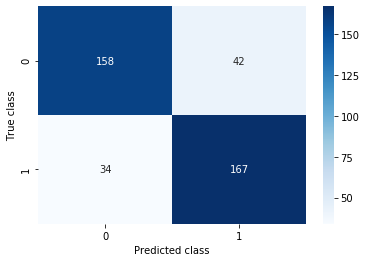

In [5]:
# logistic regression with only labels

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_label = df_label
y = df["Engagement"].values
lg_label = LogisticRegression().fit(X_label, y)
pred_label = lg_label.predict(X_label)
cf_matrix_label = confusion_matrix(y, pred_label)

ax = sns.heatmap(cf_matrix_label, annot = True, cmap = plt.cm.Blues,  fmt = "g")
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')

Text(33.0, 0.5, 'True class')

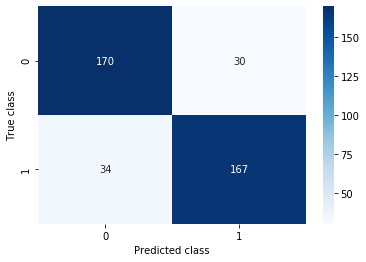

In [6]:
# logistic regression with only caption
X_caption = df_caption
lg_caption = LogisticRegression().fit(X_caption, y)
pred_caption = lg_caption.predict(X_caption)
cf_matrix_caption = confusion_matrix(y, pred_caption)

ax = sns.heatmap(cf_matrix_caption, annot = True, cmap = plt.cm.Blues,  fmt = "g")
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')

Text(33.0, 0.5, 'True class')

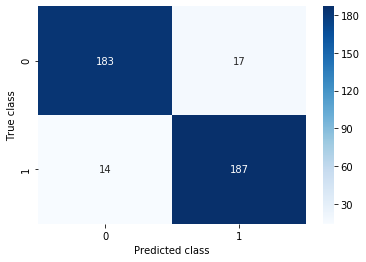

In [7]:
# logistic regression with both labels and caption
df_label = df_label.add_suffix("_label")
df_caption = df_caption.add_suffix("_caption")
X_both = df_label.merge(df_caption, left_index = True, right_index = True)
lg_both = LogisticRegression().fit(X_both, y)
pred_both = lg_both.predict(X_both)
cf_matrix_both = confusion_matrix(y, pred_both)

ax = sns.heatmap(cf_matrix_both, annot = True, cmap = plt.cm.Blues,  fmt = "g")
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')

From the three confusion matrices above, we can see that the predicion accuracy of the model built with both image labels and captions is better than those of the models built with only lables or captions. This implies that the model did not suffer from collinearity issues which means that the information contained in the images of ZARA's instagram posts is different from the captions. It also tells that Zara is doing a good job telling stories with both labels and captions.

In [8]:
coefs_both = lg_both.coef_
coefs_both_df = pd.DataFrame({"word": list(X_both.columns), "coef": coefs_both[0]})
print ("Top 10 words that have the most positive impact on engagement:")
coefs_both_df.sort_values(by = "coef", ascending = False).head(10)

Top 10 words that have the most positive impact on engagement:


,word,coef
779,dress_caption,1.135128
258,leg_label,1.096577
45,beauty_label,1.076508
1572,zarawoman_caption,1.012939
459,turquoise_label,0.879677
339,plant_label,0.790182
96,child_label,0.713658
445,top_label,0.709043
1220,print_caption,0.701619
272,long_label,0.672100


In [9]:
print ("Top 10 words that have the most negative impact on engagement:")
coefs_both_df.sort_values(by = "coef").head(10)

Top 10 words that have the most negative impact on engagement:


,word,coef
334,photography_label,-1.054460
1564,zaraman_caption,-0.927190
767,discover_caption,-0.922127
177,font_label,-0.908137
1568,zarasrpls_caption,-0.894917
1363,srpls_caption,-0.894917
589,available_caption,-0.871778
1160,outerwear_caption,-0.851278
237,jacket_label,-0.819705
691,cllctn_caption,-0.770843


### Advice for Zara

The above two tables shows the top 10 most postive and negative words that affected browser engagement based on the logistic regression model built with both image labels and captions. As we can tell, feminine topics such as a post mentioning "dress" or an image featuring legs or beauty can attract more user interactions. Thus, we recommend that Zara posts more pictures that involve those topics. In addition, images about turquoise are very popular as well, which is quite surprising since people seldom associate turquoise with Zara. However, it signals Zara could incorprate turquoise or turquoise elements in its posts as well to increase user engagement. Other than that, pictures about "plant", "child", and more generally "top", are very attrative to users too.


On the other hand, posts about mensware or some more neutral styles can have much lower engagemnt, as posts mentioning "zaraman" have the second highest negative impact on engagement, and "zarasrpls" and "srpls" are on the list as well.("srpls" is a collection that embraces a utilitarian aesthetic.) Considering a relatively large market for mensware and a current trend for neutral styles, it is recommended that Zara find ways to improve the engagement of the posts on such topics. Possible ideas might be to incorporate the elements that are previously found to be attractive, such as "plants", in their posts on these topics.

## Task C -  Topic Modeling

Two of our team members experiment LDA with different packages: lda and sklearn.decomposition.LatentDirichletAllocation, and we get similar results: pictures that focus on clothing gets higher engagement. We present two solutions below. 

### Method 1: lda

In [10]:
import nltk, lda
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
import warnings
import re
import numpy as np
warnings.filterwarnings("ignore")
import logging
logging.getLogger("requests").setLevel(logging.WARNING)

In [11]:
labels = df["Labels"]
def combine_bigram(labels): 
    tokens = re.findall('[A-Z][^A-Z]*', labels)
    tokens = [t.replace(' ','') for t in tokens]
    return ' '.join(tokens)

def tokenize_text(image_labels):
    word_tokenizer = RegexpTokenizer(r'\w+')
    return word_tokenizer.tokenize(image_labels)

labels = labels.apply(combine_bigram)
num_topic = 5
vec_words = CountVectorizer(tokenizer =tokenize_text, decode_error='ignore')
feature_words = vec_words.fit_transform(labels)

model = lda.LDA(n_topics = num_topic, n_iter = 500,random_state = 1)
model.fit(feature_words)

INFO:lda:n_documents: 401
INFO:lda:vocab_size: 497
INFO:lda:n_words: 3787
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -32073
INFO:lda:<10> log likelihood: -21880
INFO:lda:<20> log likelihood: -20982
INFO:lda:<30> log likelihood: -20757
INFO:lda:<40> log likelihood: -20725
INFO:lda:<50> log likelihood: -20707
INFO:lda:<60> log likelihood: -20662
INFO:lda:<70> log likelihood: -20565
INFO:lda:<80> log likelihood: -20607
INFO:lda:<90> log likelihood: -20582
INFO:lda:<100> log likelihood: -20573
INFO:lda:<110> log likelihood: -20541
INFO:lda:<120> log likelihood: -20577
INFO:lda:<130> log likelihood: -20539
INFO:lda:<140> log likelihood: -20551
INFO:lda:<150> log likelihood: -20536
INFO:lda:<160> log likelihood: -20495
INFO:lda:<170> log likelihood: -20534
INFO:lda:<180> log likelihood: -20555
INFO:lda:<190> log likelihood: -20516
INFO:lda:<200> log likelihood: -20500
INFO:lda:<210> log likelihood: -20446
INFO:lda:<220> log likelihood: -20420
INFO:lda:<230> log li

In [12]:
topic_word = model.topic_word_
doc_topic = model.doc_topic_
doc_topic = pd.DataFrame(doc_topic)
df = df.join(doc_topic)


topics = pd.DataFrame(topic_word)
topics.columns = vec_words.get_feature_names()
topic_transpose = topics.transpose()
topic_transpose.to_excel("topic_word.xlsx")
df.to_excel("doc_topic.xlsx")

In [13]:
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vec_words.get_feature_names())[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: font text graphics yellow line logo art plant illustration
Topic 1: shoulder leg beauty photoshoot fashion dress clothing sitting footwear
Topic 2: outerwear fashion clothing sleeve jacket formalwear suit standing coat
Topic 3: hair hairstyle face beauty chin lip eyebrow skin forehead
Topic 4: black white photography and photograph snapshot standing monochrome monochromephotography


topic1: design/illustration

topic2: summerwear/dress

topic3: outerwear

topic4: face portrait

topic5: monochrome

In [14]:
#assign topic names
df = df.rename(columns={0: 'design', 1: 'summerwear/dress', 2:'outerwear',3:'face_portrait',4:'monochrome'})

#filter for highest and lowest quartile
high_quartile = df[df['Engagement_score'] > df['Engagement_score'].quantile(0.75)]
high_quartile['Engagement_level'] = 'High'
high_quartile.head()

,Caption,Comments,Likes,URL,Labels,Comments_norm,Likes_norm,Engagement_score,Engagement,design,summerwear/dress,outerwear,face_portrait,monochrome,Engagement_level
8,FW20 Campaign. Woman Collection\nCreative Dire...,412,88977,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Photograph Standing People Suit Black-and-whit...,0.126925,0.329376,0.207906,1,0.007407,0.007407,0.377778,0.007407,0.600000,High
20,Archive Collection 1996/2012 — Launching a re-...,567,130499,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Hair Beauty Skin Photo shoot Model Fashion mod...,0.174677,0.483083,0.298039,1,0.009524,0.676190,0.009524,0.295238,0.009524,High
24,Halloween collection for Kids @zarakids #zarakids,1519,22724,https://scontent-dfw5-1.cdninstagram.com/v/t51...,Cool Fashion T-shirt Child Outerwear Headgear ...,0.467961,0.084120,0.314424,1,0.010526,0.010526,0.957895,0.010526,0.010526,High
25,Credits. New season! Get the kids ready for Ha...,996,21585,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Text Music Helmet Music artist Font Headgear F...,0.306839,0.079904,0.216065,1,0.580952,0.009524,0.104762,0.295238,0.009524,High
27,Customize your shirt by embroidering your chos...,598,75211,https://scontent-dfw5-1.cdninstagram.com/v/t51...,Clothing Blue White Fashion Shoulder Fashion m...,0.184227,0.278417,0.221903,1,0.009524,0.676190,0.295238,0.009524,0.009524,High


In [15]:
low_quartile = df[df['Engagement_score'] < df['Engagement_score'].quantile(0.25)]
low_quartile['Engagement_level'] = 'Low'
low_quartile.head()

,Caption,Comments,Likes,URL,Labels,Comments_norm,Likes_norm,Engagement_score,Engagement,design,summerwear/dress,outerwear,face_portrait,monochrome,Engagement_level
1,FW20 Campaign. Kids Collection\nCreative Direc...,118,37962,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Sky Darkness Room Adventure game Music venue N...,0.036352,0.140528,0.078023,0,0.676190,0.009524,0.009524,0.009524,0.295238,Low
3,FW20 Campaign. Man Collection\nCreative Direct...,100,34570,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Hair Face Hairstyle Eyebrow Forehead Chin Head...,0.030807,0.127972,0.069673,0,0.009524,0.009524,0.009524,0.961905,0.009524,Low
4,FW20 Campaign. Man Collection\nCreative Direct...,181,34182,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Snapshot Standing Hand Arm Human Photography S...,0.055761,0.126535,0.084071,0,0.009524,0.009524,0.009524,0.295238,0.676190,Low
5,FW20 Campaign. Man Collection\nCreative Direct...,139,44365,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Clothing Fashion Outerwear Beige Fashion desig...,0.042822,0.164231,0.091386,0,0.013333,0.146667,0.813333,0.013333,0.013333,Low
7,FW20 Campaign. Woman Collection\nCreative Dire...,118,19642,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Photograph Black-and-white Photography Monochr...,0.036352,0.072711,0.050896,0,0.008000,0.008000,0.088000,0.008000,0.888000,Low


In [16]:
compare = pd.concat([high_quartile,low_quartile])
compare.groupby(by = ['Engagement_level'])[['design','summerwear/dress','outerwear','face_portrait','monochrome']].mean()

,design,summerwear/dress,outerwear,face_portrait,monochrome
Engagement_level,,,,,
High,0.091210,0.405256,0.266784,0.115196,0.121554
Low,0.206295,0.130147,0.296713,0.169367,0.197477


Zara's post gains high engagment when the content is about summerwear or dress. And customers do not like design/illustration, face_portrait and monochrome photography

### Method 2: sklearn.lda

In [17]:
zara = pd.read_excel("Combined.xlsx")

# Print head
zara.head()

labels = zara["Labels"]
labels.head()


0    Clothing Fashion Outerwear Fur Street fashion ...
1    Sky Darkness Room Adventure game Music venue N...
2          Cool Fashion Jeans Sitting Denim Shoe Style
3    Hair Face Hairstyle Eyebrow Forehead Chin Head...
4    Snapshot Standing Hand Arm Human Photography S...
Name: Labels, dtype: object

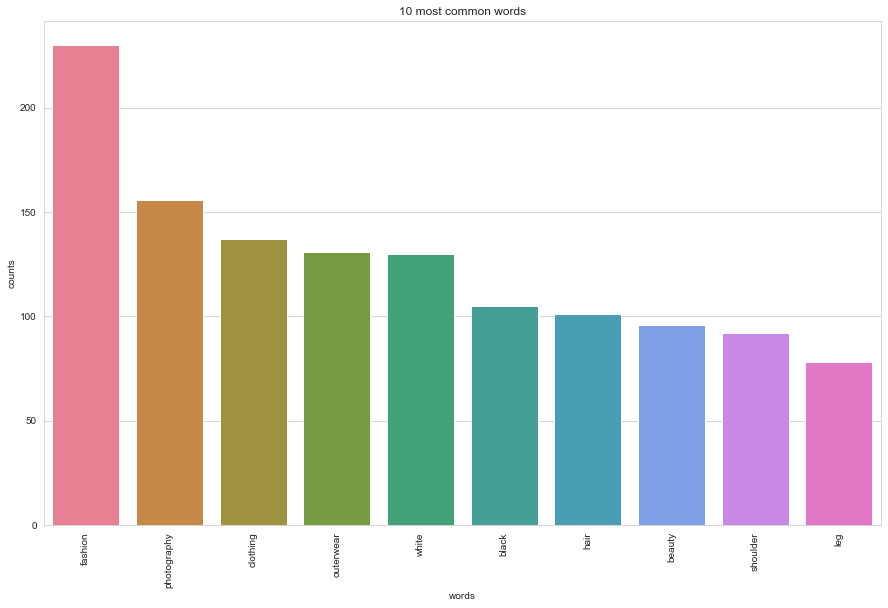

In [18]:
# Load the regular expression library
import re

# Remove punctuation
labels = labels.map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
labels = labels.map(lambda x: x.lower())
# Print out the first rows of papers
labels.head()

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(labels)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [19]:
# For topics
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 4
number_words = 8

# Create and fit the LDA model
lda = LDA(n_components=number_topics, random_state = 23)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
fashion clothing outerwear sleeve dress shoulder white neck

Topic #1:
photography photo shoot beauty sitting hair shoulder model

Topic #2:
hair hairstyle face beauty skin chin lip eyebrow

Topic #3:
photography white black leg monochrome photograph fashion standing


topic1: fashion/clothing

topic2: photography/portrait

topic3: face portrait

topic4: monochrome

In [20]:
def get_topics(model, count_vectorizer, n_top_words):
    topics = []
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        topics.append(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return topics

topics = get_topics(lda, count_vectorizer, number_words)

def count_topic(x,topic):
    count = 0
    for i in x:
        if i in topic:
            count += 1
    return count

topic1=topics[0].split()
topic2=topics[1].split()
topic3=topics[2].split()
topic4=topics[3].split()

prueba = zara
prueba["splitted"] = prueba["Labels"].apply(lambda x: x.lower().split())
prueba["n"] = prueba["Labels"].apply(lambda x: len(x.split()))
prueba["top1_count"] = prueba["splitted"].apply(lambda x: count_topic(x,topic1))
prueba["t1_weight"] = prueba["top1_count"]/prueba["n"]
del prueba["top1_count"]

prueba["top2_count"] = prueba["splitted"].apply(lambda x: count_topic(x,topic2))
prueba["t2_weight"] = prueba["top2_count"]/prueba["n"]
del prueba["top2_count"]

prueba["top3_count"] = prueba["splitted"].apply(lambda x: count_topic(x,topic3))
prueba["t3_weight"] = prueba["top3_count"]/prueba["n"]
del prueba["top3_count"]

prueba["top4_count"] = prueba["splitted"].apply(lambda x: count_topic(x,topic4))
prueba["t4_weight"] = prueba["top4_count"]/prueba["n"]
del (prueba["top4_count"],prueba["splitted"],prueba["n"])

cols_to_norm = ['Comments','Likes']
prueba[cols_to_norm] = prueba[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

prueba["engagement"] = 0.4*prueba["Likes"] + 0.6*prueba["Comments"]

prueba.head()

,Caption,Comments,Likes,URL,Labels,t1_weight,t2_weight,t3_weight,t4_weight,engagement
0,FW20 Campaign. Kids Collection\nCreative Direc...,0.097209,0.216957,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Clothing Fashion Outerwear Fur Street fashion ...,0.416667,0.083333,0.0,0.333333,0.145108
1,FW20 Campaign. Kids Collection\nCreative Direc...,0.019128,0.082693,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Sky Darkness Room Adventure game Music venue N...,0.000000,0.076923,0.0,0.076923,0.044554
2,FW20 Campaign. Kids Collection\nCreative Direc...,0.041706,0.152264,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Cool Fashion Jeans Sitting Denim Shoe Style,0.142857,0.142857,0.0,0.142857,0.085929
3,FW20 Campaign. Man Collection\nCreative Direct...,0.013484,0.069291,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Hair Face Hairstyle Eyebrow Forehead Chin Head...,0.000000,0.200000,0.6,0.000000,0.035807
4,FW20 Campaign. Man Collection\nCreative Direct...,0.038884,0.067758,https://scontent-dfw5-2.cdninstagram.com/v/t51...,Snapshot Standing Hand Arm Human Photography S...,0.000000,0.181818,0.0,0.272727,0.050433


In [21]:
# For quantiles
prueba["engagement"].quantile([0,0.25,0.5,0.75,1])

lower_mask = (prueba["engagement"] < prueba["engagement"].quantile(0.25))
upper_mask = (prueba["engagement"] > prueba["engagement"].quantile(0.75))

weights = {
    "topic 1": [prueba[lower_mask]["t1_weight"].mean(),prueba[upper_mask]["t1_weight"].mean()],
    "topic 2": [prueba[lower_mask]["t2_weight"].mean(),prueba[upper_mask]["t2_weight"].mean()],
    "topic 3": [prueba[lower_mask]["t3_weight"].mean(),prueba[upper_mask]["t3_weight"].mean()],
    "topic 4": [prueba[lower_mask]["t4_weight"].mean(),prueba[upper_mask]["t4_weight"].mean()]
}

weights_df = pd.DataFrame(weights)
weights_df.index = ["lower","upper"]
weights_df = weights_df.rename(columns={'topic 1': 'fashion/clothing', 'topic 2': 'photography/portrait', 'topic 3':'face portrait','topic 4':'monochrome'})
weights_df.head()


,fashion/clothing,photography/portrait,face portrait,monochrome
lower,0.144251,0.144427,0.070527,0.185582
upper,0.236596,0.198157,0.092783,0.181431


Engagement is high when zara posts photos about clothings and models.

## Task D - Advice for Zara

Recommendations for Zara based on Task B can be found under the section **Task B - Logistic Regression**. 

From task C we are able to conclude that instagram users are more interested in Zara's posts when the image/photo is about fashion clothing, specifically with the summerwear/dress topic which contains labels "shoulder leg beauty photoshoot fashion dress clothing sitting footwear". 

One possible cause of this observation is that summer season just passed and the historical instagram posts we collected reflects cusotmers' high engagement with in season apparel. Another reason, by looking at the label words which form the topic, could be that there is a trend of off-shoulder top/dress or tank top that increases customers' engagment.

Hence Zara can post more pictures about in season clothing and perhaps advertise more about off-shoulder knitwear or sweater tank in the coming autumn&winter season.

Users' engagement with "outerwear" topic is quite unpredictable considering that both low-engagemnt posts and high-engagement posts have the same proportion of this topic. Thus the popularity of such posts may vary depending on the design of outerwears.

We also observed that users are less engaged with photos that are about graphics/fonts/illustrations, or face portraits or monochrome photography. These three topics have one thing in common: customers are not able to see the actual design of the clothing. 

Zara loves to post monochrome photography according to our browsing of its instagram accounts, however, since users can no longer see the color of clothings, they are less engaged. In terms of face portraits, Zara mostly use them to advertise accessories. However, sometimes Zara also uses face portraits to advertersie clothing where users could only check out the collar design. We speculate that those posts lead to less engagment.

After investigating the low-engagement post elements, we suggest Zara to post pictures with the complete look of its clothing where users are able to see the entire design.


